# Exercise 3 (Training without Bayes Optimization)

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import pandas as pd
import pickle

path_train = '../pickle/fraud/data/preprocessed_train.pkl'
path_test = '../pickle/fraud/data/preprocessed_test.pkl'
data_train:pd.DataFrame = pickle.load(open(path_train, 'rb'))
data_test = pickle.load(open(path_test, 'rb'))

print(data_train.shape)
print(data_test.shape)

(472432, 53)
(118108, 53)


## Undersampling

In [4]:
data_train = data_train.drop(data_train[data_train['isFraud'] == 0].sample(n=data_train[data_train['isFraud'] == 0].shape[0]-16421).index)
print(data_train.shape)


(32842, 53)


## Oversampling

In [5]:
from collections import Counter
from imblearn.over_sampling import ADASYN

X_train, y_train = data_train.drop('isFraud', axis=1), data_train['isFraud']
X_test, y_test = data_test.drop('isFraud', axis=1), data_test['isFraud']

ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

In [6]:
print("Original train")
print(f"0: {Counter(y_train)[0]} ({round(Counter(y_train)[0]/len(y_train)*100, 1)}%)")
print(f"1: {Counter(y_train)[1]} ({round(Counter(y_train)[1]/len(y_train)*100, 1)}%)")
print()
print("Resampled train")
print(f"0: {Counter(y_train_res)[0]} ({round(Counter(y_train_res)[0]/len(y_train_res)*100, 1)}%)")
print(f"1: {Counter(y_train_res)[1]} ({round(Counter(y_train_res)[1]/len(y_train_res)*100, 1)}%)")
print()
print("Test")
print(f"0: {Counter(y_test)[0]} ({round(Counter(y_test)[0]/len(y_test)*100, 1)}%)")
print(f"1: {Counter(y_test)[1]} ({round(Counter(y_test)[1]/len(y_test)*100, 1)}%)")

Original train
0: 16421 (50.0%)
1: 16421 (50.0%)

Resampled train
0: 16421 (50.0%)
1: 16421 (50.0%)

Test
0: 113866 (96.4%)
1: 4242 (3.6%)


## Training

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf' : 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__max_depth': list(range(1, nb_col + 1)),
            'model__n_estimators': [10, 50, 100, 200],
            
        },    
    },

    {
        'name_clf' : 'SVC (poly)',
        'model': SVC(random_state=42, kernel='poly'),
        'scalers' : {
            'scaler': [None, MinMaxScaler(), StandardScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-3, 4)],
        }
    },

    {
        'name_clf' : 'SVC (linear)',
        'model': SVC(random_state=42, kernel='linear'),
        'scalers' : {
            'scaler': [MinMaxScaler(), StandardScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-3, 4)],
        }
    },

    {
        'name_clf' : 'SVC (rbf)',
        'model': SVC(random_state=42, kernel='rbf'),
        'scalers' : {
            'scaler': [None, MinMaxScaler(), StandardScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-3, 4)],
        }
    },

    {
        'name_clf' : 'SVC (sigmoid)',
        'model': SVC(random_state=42, kernel='sigmoid'),
        'scalers' : {
            'scaler': [None, MinMaxScaler(), StandardScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-3, 4)],
        }
    },    
]

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
from utils import model_evaluation_clf
import os

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    model_path = f"../pickle/fraud/models/GridSearchCV/{model_name}.pkl"
    model_time = f"../pickle/fraud/CPU_time/GridSearchCV/{model_name}_time.pkl"
    if not os.path.exists(model_path) or not os.path.exists(model_time):
        print(f'Training {model_name}...')

        model = dict_clf['model']

        steps = [
            ('scaler', None),
            ('model', model),
        ]

        pipeline = Pipeline(steps)

        param_grid = {
            **dict_clf['scalers'],
            **dict_clf['grid']
        }

        clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')

        warnings.filterwarnings("ignore")
        start_time = time()
        clf.fit(X_train_res, y_train_res)
        end_time = time()
        duration = round(end_time - start_time, 1)
        print(f"CPU Time: {duration}s")

        pickle.dump(clf, open(model_path, 'wb'))
        pickle.dump(duration, open(model_time, 'wb'))
    else:
        clf = pickle.load(open(model_path, 'rb'))
        duration = pickle.load(open(model_time, 'rb'))

    
    print(f"Best params {model_name}: \n{clf.best_params_}")

    eval = model_evaluation_clf(clf, X_test, y_test)
    
    models[model_name] = clf

    results.loc[nb_res] = [model_name, duration, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc']]
    nb_res += 1

    print()

Best params Random Forest: 
{'model__max_depth': 19, 'model__n_estimators': 200, 'scaler': None}

Best params SVC (poly): 
{'model__C': 1000, 'scaler': MinMaxScaler()}

Best params SVC (linear): 
{'model__C': 100, 'scaler': StandardScaler()}

Best params SVC (rbf): 
{'model__C': 10, 'scaler': StandardScaler()}

Best params SVC (sigmoid): 
{'model__C': 0.01, 'scaler': StandardScaler()}



In [9]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

        Model  CPU time  Accuracy  Precision  Recall  f1-score   AUC
Random Forest    1314.7     0.965      0.506   0.990     0.670 0.977
    SVC (rbf)    1032.8     0.963      0.492   0.952     0.649 0.958
   SVC (poly)   14512.0     0.964      0.501   0.949     0.656 0.957
 SVC (linear)   36147.3     0.940      0.367   0.924     0.525 0.932
SVC (sigmoid)     854.1     0.837      0.135   0.656     0.224 0.750


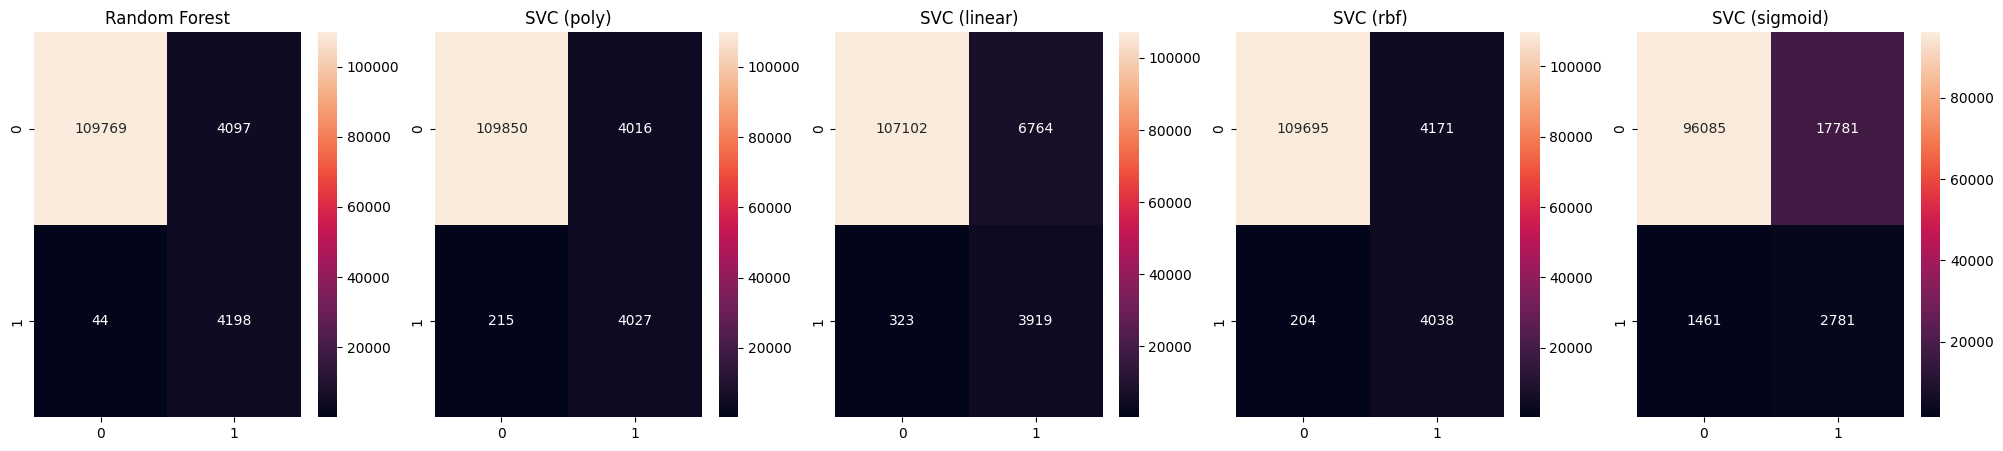

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(model_name)

plt.show()

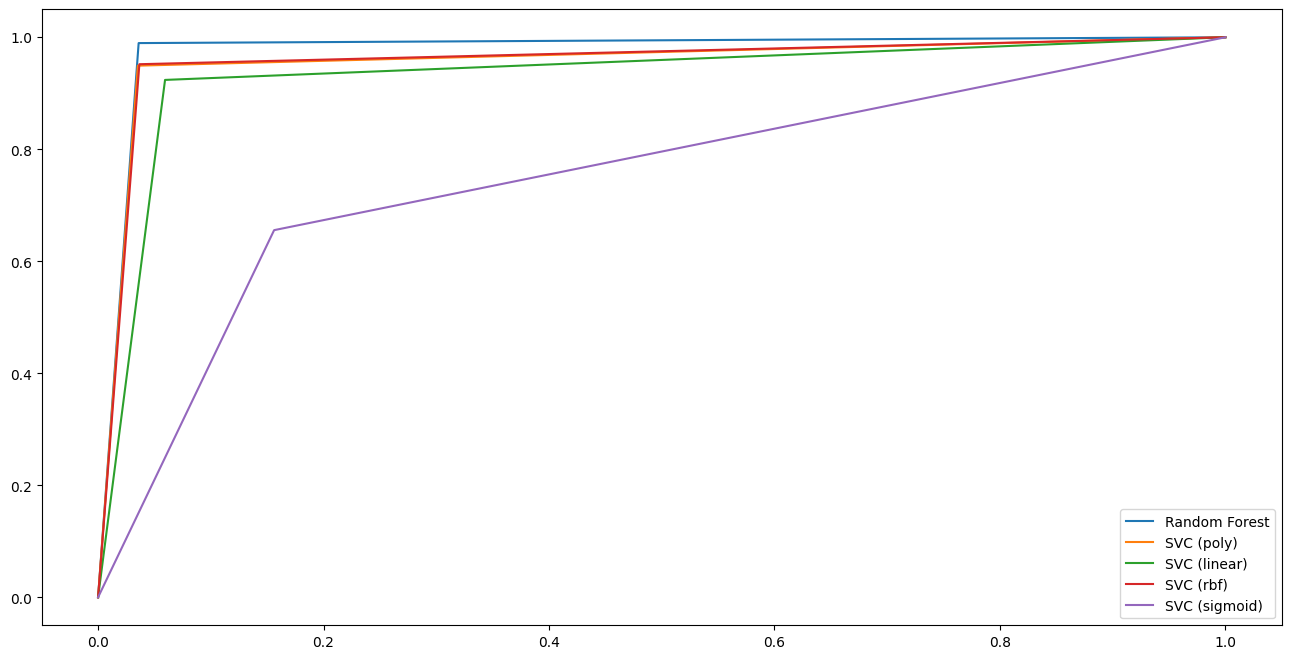

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(16, 8))

for model_name in models.keys():
    model = models[model_name]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)

plt.legend()
plt.show()

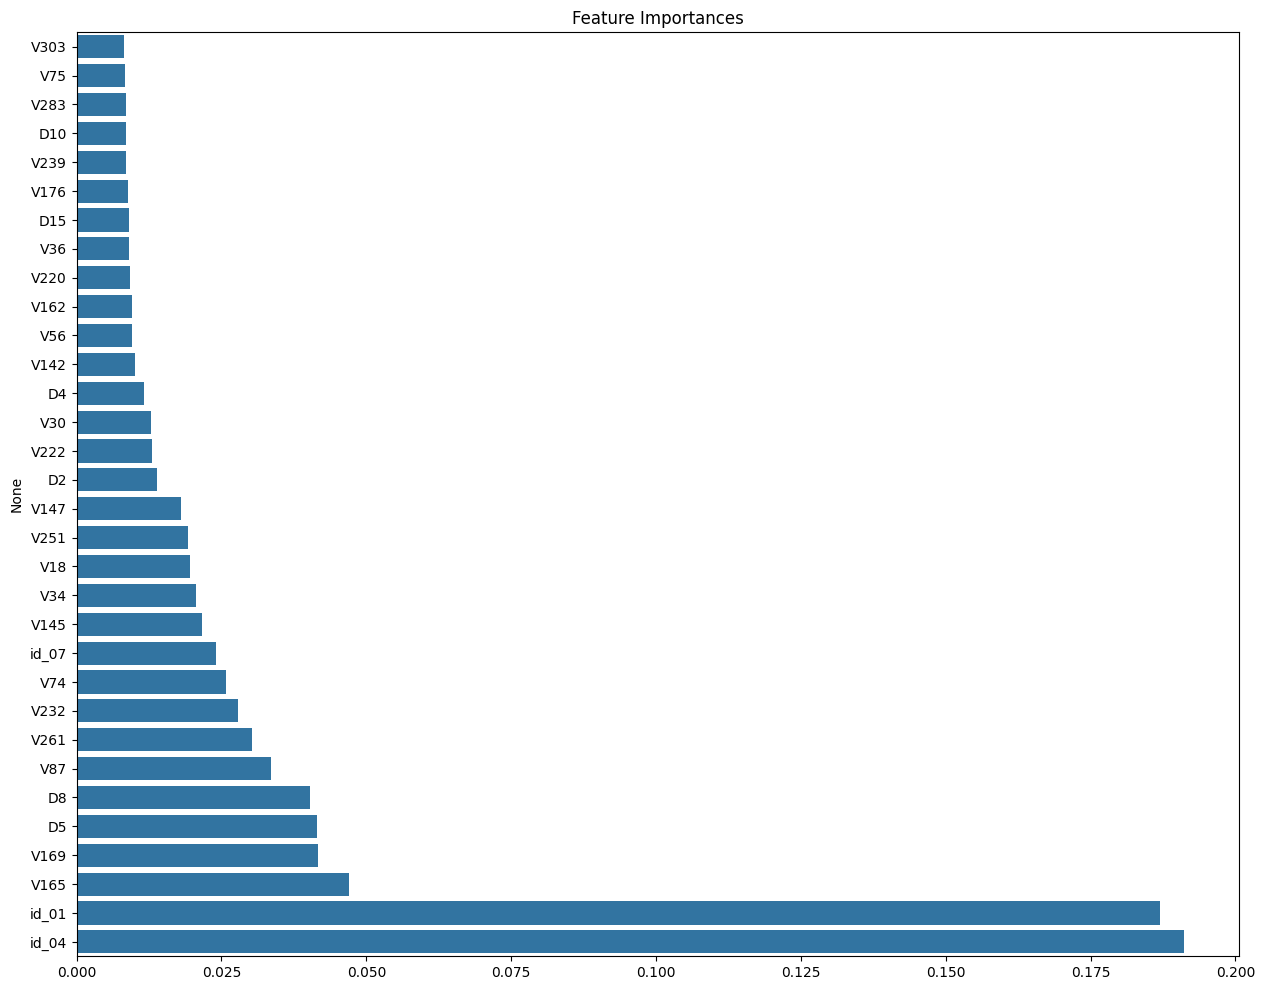

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

model = models['Random Forest']

importances = model.best_estimator_.named_steps['model'].feature_importances_
indices = importances.argsort()[20:]

plt.figure(figsize=(15, 12))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.show()